# Project

In [127]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import folium
from folium.plugins import TimestampedGeoJson
import branca.colormap as cm
from sklearn.neighbors import BallTree
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

R           = 6371.0
TOTAL_LEN   = 24 * 12
SEQ_LEN     = 12
HORIZON     = 4
INPUT_SIZE  = 3
BATCH_SIZE  = 64
HIDDEN_SIZE = 128
EPOCHS      = 40
LR          = 1e-5
RADIUS_KM   = 15
DT          = 5                  # mins
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"

In [86]:
# Read data
def load_raw_data(traffic_file, incident_file):
    traffic_df = pd.read_csv(traffic_file)
    incident_df= pd.read_csv(incident_file, parse_dates=["Timestamp"])
    
    # Data cleaning
    col_names = ['Timestamp', 'Station', 'District', 'Freeway', 'Direction', 'Lane Type',
           'Station Length', 'Samples', 'Observed Percentage', 'Total Flow',
           'Avg Occupancy', 'Avg Speed']
    traffic_df = traffic_df.iloc[:, :len(col_names)]
    traffic_df.columns = col_names
    traffic_df.dropna(inplace=True)
    traffic_df['Timestamp'] = pd.to_datetime(traffic_df['Timestamp'])
    traffic_df = traffic_df.drop('District', axis=1)
    
    incident_df.dropna(inplace=True)
    incident_df = incident_df[incident_df['District'] == 7.0]
    incident_df = incident_df.drop('District', axis=1)
    
    return traffic_df, incident_df

def load_sensor_data(sensor_file):
    sensor_df  = pd.read_csv(sensor_file, sep="\t")
    sensor_df = sensor_df.iloc[:, :-4]
    sensor_df = sensor_df.drop(['City', 'Length', 'District'], axis=1)
    sensor_df = sensor_df.dropna()
    
    return sensor_df

In [87]:
# Geography plot
def plot_geography(dataframe, title, info):
    m = folium.Map(location=[dataframe['Latitude'].mean(), dataframe['Longitude'].mean()], zoom_start=12)
    for index, row in dataframe.iterrows():
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=row[info],
            icon=folium.Icon(color='red', icon='info-sign')
        ).add_to(m)
    m.save(title + '_map.html')
    return m

In [88]:
# Helper functions to compute distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi   = np.radians(lat2 - lat1)
    dlambda= np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1-a))

# Build a time series dataset of all sensors
def build_sensor_sequences(traffic_df, incident_df, sensor_df):
    sensors = traffic_df["Station"].unique().tolist()
    sequence = pd.DataFrame(columns=sensors )
    sequence.set_index(traffic_df["Timestamp"].unique())
    for _, row in traffic_df.iterrows():
        sequence.loc[row["Timestamp"], row["Station"]] = row["Total Flow"]
    return sequence

# Attach sensors to incidents
def attach_sensors_by_route(inc_df, sens_df, radius_km = RADIUS_KM):
    mapping= {}
    for _, inc in inc_df.iterrows():
        freeway = inc["Freeway Number"]
        direction = inc["Freeway Direction"]
        lat_a, lon_a = inc["Latitude"], inc["Longitude"]
        cond = (sens_df["Fwy"] == freeway) & (sens_df["Dir"] == direction)
        candidates = sens_df.loc[cond]
        sid_list = []
        for _, s in candidates.iterrows():
            dist = haversine(lat_a, lon_a, s["Latitude"], s["Longitude"])
            if dist <= radius_km:
                sid_list.append(int(s["ID"]))
        mapping[int(inc["Incident ID"])] = sid_list
    return mapping

def attach_all(inc_df, sens_df):
    sens_coords = np.radians(sens_df[["Latitude", "Longitude"]].to_numpy()[:, ::-1])
    tree = BallTree(sens_coords, metric="haversine")
    radius_rad = RADIUS_KM / R
    inc_coords = np.radians(inc_df[["Latitude", "Longitude"]].to_numpy()[:, ::-1])
    all_neighbors = tree.query_radius(inc_coords, r=radius_rad)
    mapping = {}
    for inc_idx, sensor_idx_array in enumerate(all_neighbors):
        inc_id = int(inc_df.iloc[inc_idx]["Incident ID"])
        mapping[inc_id] = sens_df.iloc[sensor_idx_array]["ID"].astype(int).tolist()
    return mapping
            

# Build data sequences for LSTM
def build_sequences(traffic_df, incident_df, sensor_df, mapping):
    traffic_df = traffic_df.set_index(["Station", "Timestamp"]).sort_index()
    sensor_df = sensor_df.set_index(["ID"])
    samples= []

    for _, inc in incident_df.iterrows():
        inc_id = int(inc["Incident ID"])
        inc_t_aligned = pd.Timestamp(inc["Timestamp"]).round("5min")
        for sid in mapping.get(inc_id, []):
            past_rng = pd.date_range(end=inc_t_aligned, periods=SEQ_LEN, freq="5min")
            fut_rng  = pd.date_range(start=inc_t_aligned + pd.Timedelta(minutes=DT),
                                     periods=HORIZON, freq="5min")
            try:
                past_flow = traffic_df.loc[(sid, past_rng), "Total Flow"].values.astype(float)
                fut_flow  = traffic_df.loc[(sid, fut_rng ), "Total Flow"].values.astype(float)
                distance  = haversine(inc["Latitude"], inc["Longitude"],
                                       sensor_df.loc[sid, "Latitude"], sensor_df.loc[sid, "Longitude"])
            except KeyError:
                continue
            samples.append({"X_flow": past_flow, "Y_flow": fut_flow, "ID": sid, "distance": distance, "t_inc": inc_t_aligned})
    return samples

In [89]:
# Build a dataset for LSTM
class TrafficDataset(Dataset):
    def __init__(self, samples, mu=None, std=None):
        self.samples = samples
        flows = np.concatenate([s["X_flow"] for s in samples] + [s["Y_flow"] for s in samples])
        self.mu = mu if mu is not None else np.mean(flows)
        self.std = std if std is not None else (np.std(flows) + 1e-6)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        rows = []
        for i in range(SEQ_LEN):
            flow_n = (s["X_flow"][i] - self.mu) / self.std
            inc_fg = 1.0 if i == SEQ_LEN-1 else 0.0
            rows.append([flow_n, inc_fg, s["distance"]])
        X = torch.tensor(rows, dtype=torch.float32)                                # (T, 3)
        Y = torch.tensor((s["Y_flow"] - self.mu) / self.std, dtype=torch.float32)  # (H,)
        t = int(s["t_inc"].timestamp())
        return X, Y, s["ID"], t

In [90]:
# Build LSTM model
class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden, horizon):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden, batch_first=True)
        self.fc   = nn.Linear(hidden, horizon)

    def forward(self, x):                # (B, T, 3)
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])            # (B, H)

In [91]:
# Train the model
def run_model(model, loader, opt=None):
    train = opt is not None
    model.train() if train else model.eval()
    loss_fn = nn.MSELoss()
    total = 0.0
    for X, Y, _, _ in loader:
        X, Y = X.to(DEVICE), Y.to(DEVICE)
        loss = loss_fn(model(X), Y)
        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        total += loss.item() * X.size(0)
    return total/len(loader.dataset)

# Evaluate the model
def reg_metrics(pred, true):
    mae  = mean_absolute_error(true, pred)
    rmse = root_mean_squared_error(true, pred)
    mape = np.mean(np.abs((true - pred) / (true + 1e-6)))
    r2   = r2_score(true, pred)
    return dict(MAE=mae, RMSE=rmse, MAPE=mape, R2=r2)

def evaluate(model, loader):
    model.eval()
    all_p, all_t = [], []
    with torch.no_grad():
        for X, Y, _, _ in loader:
            pred = model(X.to(DEVICE)).cpu()
            all_p.append(pred); all_t.append(Y)
    pred = torch.cat(all_p).numpy()
    true = torch.cat(all_t).numpy()

    metrics = reg_metrics(pred, true)
    step_mse = [root_mean_squared_error(true[:,h], pred[:,h]) for h in range(HORIZON)]
    return metrics, step_mse, pred, true

In [137]:
# Visualize the loss
def plot_loss(loss_list):
    plt.figure(figsize=(8, 6))
    plt.plot(loss_list[:, 0], label='Training Loss')
    plt.plot(loss_list[:, 1], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

# Helper to convert values to colors
def flow_to_color(val, vmin, vmax, cmap):
    val = float(val)
    val = max(vmin, min(val, vmax))
    return cmap(val)

# Build a folium map
def create_layer(sensor_df, val_df, name, cmap, horizon_step=0, show=True):
    layer = folium.FeatureGroup(name=name, show=show)
    for lat, lon, val in zip(sensor_df["Latitude"], sensor_df["Longitude"], val_df[:, horizon_step]):
        clr = cmap(val)
        folium.CircleMarker(
            location=(lat, lon),
            radius=10,
            color=clr,
            fill=True,
            fill_color=clr,
            fill_opacity=0.7,
            popup=f"{val:.0f}"
        ).add_to(layer)
    return layer

# Plot differences between predicted and true values
def build_compare_map(sensor_df, preds, truth):
    center = [sensor_df["Latitude"].mean(), sensor_df["Longitude"].mean()]
    fmap = folium.Map(location=center, zoom_start=10, control_scale=True)

    # Color map
    for h in range(HORIZON):
        all_vals = np.concatenate([preds[:, h], truth[:, h]])
        vmax = all_vals.max()
        cmap = cm.LinearColormap(["green", "yellow", "red"], vmin=0.0, vmax=vmax)
    
        # Truth flow layer
        true_layer = create_layer(sensor_df, truth, f"True Flow {h+1}", cmap, h)
        true_layer.add_to(fmap)
    
        # Predicted flow layer
        pred_layer = create_layer(sensor_df, preds, f"Predicted Flow {h+1}", cmap, h)
        pred_layer.add_to(fmap)
        
        error_layer = create_layer(sensor_df, preds - truth, f"Predicted Flow {h+1}", cmap, h)

    # Legend and layer control
    cmap.caption = "Total Flow (veh / 5 min)"
    fmap.add_child(cmap)
    folium.LayerControl().add_to(fmap)
    return fmap

# Plot the predicted outcomes
def build_outcome_map(sensor_df, incident_df, vals, ids):
    center = [sensor_df["Latitude"].mean(), sensor_df["Longitude"].mean()]
    fmap = folium.Map(location=center, zoom_start=10, control_scale=True)
    vmax = float(vals.max())
    cmap = cm.LinearColormap(["green", "yellow", "red"], vmin=0.0, vmax=vmax)
    
    # Pin the incident locations
    inc_layer = folium.FeatureGroup(name="Incident Points", show=True, control=True)
    for id in ids:
        id = int(id)
        if id in incident_df["Incident ID"].values:
            # Get the incident point
            incident_point = incident_df[incident_df["Incident ID"] == id][["Latitude", "Longitude"]].values[0]
            folium.Marker(
                location=incident_point,
                icon=folium.Icon(color='red', icon='info-sign'),
                popup=f"Incident ID: {id}",
            ).add_to(inc_layer)
    inc_layer.add_to(fmap)

    for h in range(HORIZON):
        layer = create_layer(sensor_df, vals, f"{(h+1)*5} min Pred after incident", cmap, h)
        layer.add_to(fmap)

    cmap.caption = "Total Flow (veh / 5 min)"
    fmap.add_child(cmap)
    folium.LayerControl().add_to(fmap)
    return fmap

In [93]:
# Data loading and preprocessing
sensor = load_sensor_data("d07_text_meta_2023_12_22.txt")

traffic_07, incident_07= load_raw_data("d07_text_station_5min_2025_01_07.txt", "all_text_chp_incident_day_2025_01_07.csv")
mapping_07  = attach_sensors_by_route(incident_07, sensor)
samples_07 = build_sequences(traffic_07, incident_07, sensor, mapping_07)
print("Number of Samples for training:", len(samples_07))

traffic_08, incident_08= load_raw_data("d07_text_station_5min_2025_01_08.txt", "all_text_chp_incident_day_2025_01_08.csv")
mapping_08  = attach_sensors_by_route(incident_08, sensor)
samples_08 = build_sequences(traffic_08, incident_08, sensor, mapping_08)
print("Number of Samples for validation and test:", len(samples_08))

train_ds = TrafficDataset(samples_07)

val_len   = len(samples_08) // 2
val_ds, test_ds = random_split(
        TrafficDataset(samples_08, mu=train_ds.mu, std=train_ds.std),
        [val_len, len(samples_08)-val_len],
        generator=torch.Generator().manual_seed(42)
)

train_ld = DataLoader(train_ds, BATCH_SIZE, shuffle=True)
val_ld   = DataLoader(val_ds,   BATCH_SIZE)
test_ld  = DataLoader(test_ds,  BATCH_SIZE)

Number of Samples for training: 22234
Number of Samples for validation and test: 16794


Epoch 01 | train 0.9466 | val 0.9828
Epoch 02 | train 0.8533 | val 0.8203
Epoch 03 | train 0.4984 | val 0.2050
Epoch 04 | train 0.1347 | val 0.1193
Epoch 05 | train 0.1013 | val 0.0986
Epoch 06 | train 0.0875 | val 0.0875
Epoch 07 | train 0.0786 | val 0.0794
Epoch 08 | train 0.0713 | val 0.0715
Epoch 09 | train 0.0646 | val 0.0644
Epoch 10 | train 0.0585 | val 0.0565
Epoch 11 | train 0.0530 | val 0.0505
Epoch 12 | train 0.0484 | val 0.0460
Epoch 13 | train 0.0449 | val 0.0415
Epoch 14 | train 0.0424 | val 0.0385
Epoch 15 | train 0.0404 | val 0.0361
Epoch 16 | train 0.0387 | val 0.0344
Epoch 17 | train 0.0372 | val 0.0327
Epoch 18 | train 0.0358 | val 0.0313
Epoch 19 | train 0.0344 | val 0.0300
Epoch 20 | train 0.0331 | val 0.0281
Epoch 21 | train 0.0318 | val 0.0268
Epoch 22 | train 0.0305 | val 0.0255
Epoch 23 | train 0.0292 | val 0.0246
Epoch 24 | train 0.0280 | val 0.0232
Epoch 25 | train 0.0268 | val 0.0222
Epoch 26 | train 0.0258 | val 0.0211
Epoch 27 | train 0.0249 | val 0.0206
E

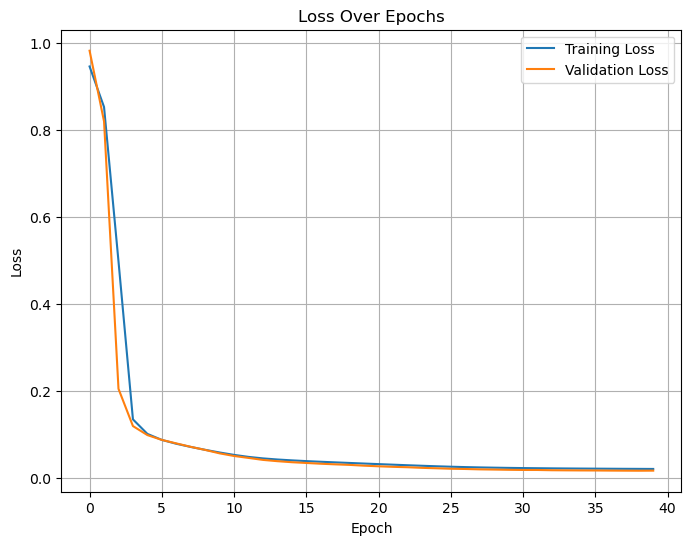

Test MSE: 0.0164


In [128]:
# Train the model
model = LSTM(input_size=INPUT_SIZE, hidden=HIDDEN_SIZE, horizon=HORIZON).to(DEVICE)
opt   = torch.optim.Adam(model.parameters(), lr=LR)

best, patience = float('inf'), 0
loss_list = []
for epoch in range(1, EPOCHS+1):
    tr, val = run_model(model, train_ld, opt), run_model(model, val_ld)
    loss_list.append((tr, val))
    print(f"Epoch {epoch:02d} | train {tr:.4f} | val {val:.4f}")
    if val < best - 1e-4:
        best, patience = val, 0
        torch.save(model.state_dict(), "best_flow.pth")
    else:
        patience += 1
        if patience >= 6:
            break

# Plot loss
loss_list = np.array(loss_list)
plot_loss(loss_list)

model.load_state_dict(torch.load("best_flow.pth", weights_only=True))
test_mse = run_model(model, test_ld)
print(f"Test MSE: {test_mse:.4f}")

In [95]:
metrics, step_mse, preds, truth = evaluate(model, test_ld)
print("Evaluation Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")
print("Step-wise MSE:")
for h, v in enumerate(step_mse):
    print(f"Step {h+1}: {v:.4f}")

Evaluation Metrics:
MAE: 0.0595
RMSE: 0.1130
MAPE: 0.2715
R2: 0.9872
Step-wise MSE:
Step 1: 0.0843
Step 2: 0.1085
Step 3: 0.1230
Step 4: 0.1362


In [108]:
# Visualize the prediction and ground truth
model.eval()
all_raw, all_pred, all_true, all_ids, all_t = [], [], [], [], []

for X_batch, Y_batch, s_id, t in test_ld:
    X_batch, Y_batch = X_batch.to(DEVICE), Y_batch.to(DEVICE)
    with torch.no_grad():
        pred_batch = model(X_batch).cpu()      # (batch, horizon)
    all_raw.append(X_batch.cpu())
    all_pred.append(pred_batch)
    all_true.append(Y_batch.cpu())
    all_ids.append(s_id)
    all_t.append(t)

raw   = torch.cat(all_raw, dim=0)[:, :, 0]     # (N, seq_len, 3)
preds = torch.cat(all_pred, dim=0)             # (N, horizon)
truth = torch.cat(all_true, dim=0)             # (N, horizon)
ids   = np.concatenate(all_ids, axis=0)
t     = np.concatenate(all_t, axis=0)

raw_denorm   = raw * train_ds.std + train_ds.mu
preds_denorm = preds * train_ds.std + train_ds.mu
truth_denorm = truth * train_ds.std + train_ds.mu

avg_raw   = raw_denorm.mean(axis=0)
avg_preds = preds_denorm.mean(axis=0)
avg_truth = truth_denorm.mean(axis=0)

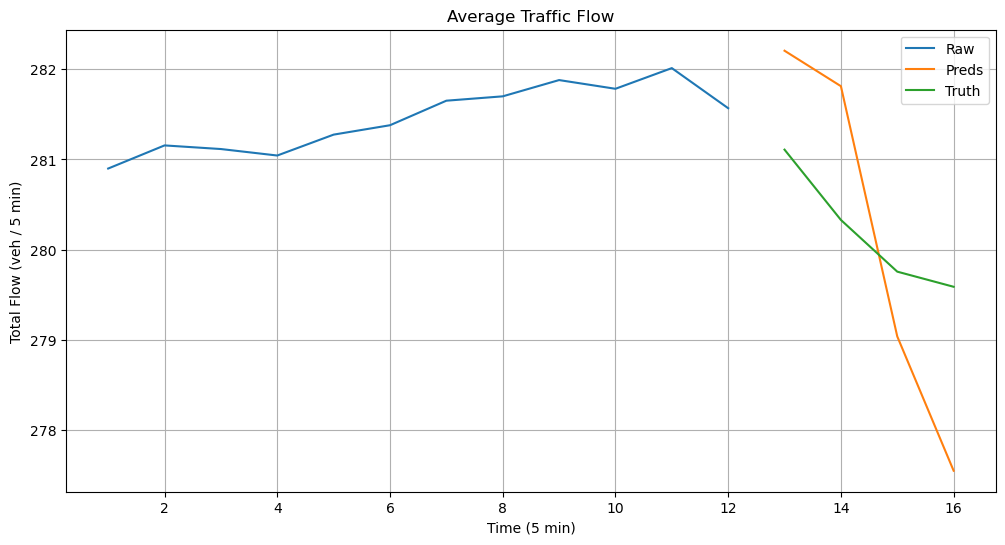

In [118]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, SEQ_LEN+1), avg_raw, label='Raw')
plt.plot(range(SEQ_LEN+1, SEQ_LEN+HORIZON+1), avg_preds, label='Preds')
plt.plot(range(SEQ_LEN+1, SEQ_LEN+HORIZON+1), avg_truth, label='Truth')
plt.xlabel('Time (5 min)')
plt.ylabel('Total Flow (veh / 5 min)')
plt.title('Average Traffic Flow')
plt.legend()
plt.grid()
plt.show()

In [98]:
def build_plot_df(sensor_df, preds, truth, ids, t):
    rows = []
    dt = pd.Timedelta(minutes=DT)
    for i in range(len(ids)):
        sid = ids[i]
        t0 = pd.Timestamp(t[i], unit='s')
        for h in range(HORIZON):
            t_cur = t0 + (h + 1) * dt
            pred_flow = float(preds[i, h])
            true_flow = float(truth[i, h])
            rows.append({
                "ID": int(sid),
                "time": t_cur.floor("5min"),
                "horizon": h+1,
                "pred": pred_flow,
                "truth": true_flow,
                "diff": pred_flow - true_flow
            })
    
    df = pd.DataFrame(rows)
    
    df = df.merge(sensor_df[["ID", "Latitude", "Longitude"]], on="ID", how="left")
    return df

def plot_df(df, horizon_step=1):
    vmin, vmax = df["truth"].min(), df["truth"].max()
    cmap = cm.LinearColormap(["green", "yellow", "red"], vmin=vmin, vmax=vmax)
    
    features_truth = []
    features_pred  = []
    for r in df.itertuples():
        clr_truth = cmap(r.truth)
        clr_pred  = cmap(r.pred)
        features_truth.append({
            "type": "Feature",
            "geometry": {"type":"Point",
                         "coordinates":[r.Longitude, r.Latitude]},
            "properties": {
                "time":  r.time.isoformat(),
                "popup": f"s:{r.ID}<br>truth:{r.truth:.1f}",
                "icon": "circle",
                "iconstyle": {
                    "fillColor": clr_truth,
                    "color": "white",
                    "fillOpacity": 0.9,
                    "radius": 8
                }
            }
        })
        features_pred.append({
            "type": "Feature",
            "geometry": {"type":"Point",
                         "coordinates":[r.Longitude, r.Latitude]},
            "properties": {
                "time":  r.time.isoformat(),
                "popup": f"s:{r.ID}<br>pred:{r.pred:.1f}",
                "icon": "circle",
                "iconstyle": {
                    "fillColor": clr_pred,
                    "color": "black",
                    "fillOpacity": 0.9,
                    "radius": 8
                }
            }
        })
        
    m = folium.Map(location=[df.Latitude.mean(), df.Longitude.mean()], zoom_start=11, control_scale=True)
    TimestampedGeoJson(
        {"type":"FeatureCollection","features":features_truth},
        duration="PT5M", period="PT5M", add_last_point= False, auto_play=False
    ).add_to(m)
    TimestampedGeoJson(
        {"type":"FeatureCollection","features":features_pred},
        duration="PT5M", period="PT5M", add_last_point= False, auto_play=False
    ).add_to(m)
    cmap.caption = f"Flow (horizon {horizon_step})"
    cmap.add_to(m)
    m.save(f"day_h{horizon_step}.html")

In [99]:
df_map = build_plot_df(sensor, preds_denorm, truth_denorm, ids, t)
plot_df(df_map, horizon_step=2)

In [ ]:
def get_example(traffic_df,  sensor_df, inc):
    traffic_df = traffic_df.set_index(["Station", "Timestamp"]).sort_index()
    sensor_df = sensor_df.set_index(["ID"])
    examples = []
    inc_t_aligned = pd.Timestamp(inc["Timestamp"]).round("5min")
    past_rng = pd.date_range(end=inc_t_aligned, periods=SEQ_LEN, freq="5min")
    fut_rng  = pd.date_range(start=inc_t_aligned + pd.Timedelta(minutes=DT), periods=HORIZON, freq="5min")
    for sid in traffic_df["Station"].unique():
        try:
            past_flow = traffic_df.loc[(sid, past_rng), "Total Flow"].values.astype(float)
            fut_flow  = traffic_df.loc[(sid, fut_rng ), "Total Flow"].values.astype(float)
            distance  = haversine(inc["Latitude"], inc["Longitude"],
                                   sensor_df.loc[sid, "Latitude"], sensor_df.loc[sid, "Longitude"])
        except KeyError:
            continue
        examples.append({"X_flow": past_flow, "Y_flow": fut_flow, "ID": sid, "distance": distance, "t_inc": inc_t_aligned})

In [140]:
# Compare map
fmap = build_compare_map(sensor, preds_denorm, truth_denorm)
fmap.save("flow_compare_map.html")

In [101]:
# Analyze map
fmap_outcome = build_outcome_map(sensor, incident_08, preds_denorm, ids)
fmap_outcome.save("flow_outcome_map.html")